# Classification and Regression in MLRepo
> Let's actually evaluate the usefulness of these embeddings on downstream tasks

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import anndata

mlrepo = anndata.read_h5ad("../data/mlrepo5.h5ad")

In [3]:
mlrepo.obs.columns

Index(['ravel_black-hispanic', 'ravel_nugent-category', 'ravel_nugent-score',
       'ravel_ph', 'ravel_white-black', 'dataset', 'gevers_ileum',
       'gevers_pcdai-ileum', 'gevers_pcdai-rectum', 'gevers_rectum',
       'sokol_healthy-cd', 'sokol_healthy-uc', 'yatsunenko_baby-age',
       'yatsunenko_malawi-venezuela', 'yatsunenko_sex',
       'yatsunenko_usa-malawi', 'hmp_gastro-oral', 'hmp_sex',
       'hmp_stool-tongue-paired', 'hmp_sub-supragingivalplaque-paired',
       'cho_control-ct-cecal', 'cho_control-ct-fecal',
       'cho_penicillin-vancomycin-cecal', 'cho_penicillin-vancomycin-fecal',
       'turnbaugh_obese-lean-all'],
      dtype='object')

In [7]:
# How many samples does each dataset have?

(~mlrepo.obs.isna()).sum(axis=0)

ravel_black-hispanic                    199
ravel_nugent-category                   342
ravel_nugent-score                      388
ravel_ph                                388
ravel_white-black                       200
dataset                               10037
gevers_ileum                            140
gevers_pcdai-ileum                       67
gevers_pcdai-rectum                      51
gevers_rectum                           160
sokol_healthy-cd                         74
sokol_healthy-uc                         59
yatsunenko_baby-age                      49
yatsunenko_malawi-venezuela              54
yatsunenko_sex                          129
yatsunenko_usa-malawi                   150
hmp_gastro-oral                        2070
hmp_sex                                 180
hmp_stool-tongue-paired                 404
hmp_sub-supragingivalplaque-paired      408
cho_control-ct-cecal                     17
cho_control-ct-fecal                     18
cho_penicillin-vancomycin-cecal 

In [33]:
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, r2_score, mean_absolute_error, mean_squared_error
import geoopt
from manify.predictors.decision_tree import ProductSpaceRF
from manify.manifolds import ProductManifold
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Configuration
# TASK = "classification"  # or "regression"
TASK = "regression"
MODEL = ProductSpaceRF
FOLDS = 5

# Dataset and embedding configuration
DATASETS = mlrepo.obs.columns.drop("dataset")
REGRESSION_DATASETS = [
    "ravel_nugent-score",
    "ravel_ph",
    "gevers_pcdai-ileum",
    "gevers_pcdai-rectum",
    "yatsunenko_baby-age",
]
CLASSIFICATION_DATASETS = [d for d in DATASETS if d not in REGRESSION_DATASETS]
DATASETS_FINAL = REGRESSION_DATASETS if TASK == "regression" else CLASSIFICATION_DATASETS

EMBEDDINGS = [
    "raw",
    "H2",
    "H4",
    "H8",
    "H16",
    "H32",
    "H64",
    "H128",
    "E2",
    "E4",
    "E8",
    "E16",
    "E32",
    "E64",
    "E128",
    "dnabert-s",
]
METRICS = ["accuracy", "f1", "auc"] if TASK == "classification" else ["r2", "mae", "rmse"]

# Initialize Poincare Ball manifold
MAN = geoopt.PoincareBall()


def load_existing_results():
    """Load existing results and return completed runs set and scores dataframe"""
    scores = pd.DataFrame(columns=["task", "embedding", "fold", "metric", "score"])
    completed_runs = set()

    for task in DATASETS_FINAL:
        result_path = f"../results/benchmark_scores_{task}.csv"
        if os.path.exists(result_path):
            task_scores = pd.read_csv(result_path)
            scores = pd.concat([scores, task_scores], ignore_index=True)

            # Create a set of (task, embedding, fold, metric) tuples for faster lookup
            for _, row in task_scores.iterrows():
                completed_runs.add((row["task"], row["embedding"], row["fold"], row["metric"]))

            print(f"Loaded existing results for {task}: {len(task_scores)} entries")

    return scores, completed_runs


def get_embedding(mlrepo_filtered, embedding_name):
    """Get embedding data and product manifold"""
    if embedding_name == "raw":
        X = mlrepo_filtered.X
        pm = ProductManifold(signature=[(0, mlrepo_filtered.X.shape[1])])
    elif embedding_name.startswith("H"):
        # Convert to hyperbolic space
        X = torch.tensor(mlrepo_filtered.obsm[embedding_name])
        X_sqnorm = torch.sum(X**2, axis=-1)
        X_t = (1 + X_sqnorm) / (1 - X_sqnorm)
        X_s = 2 * X / (1 - X_sqnorm[:, None])
        X = torch.hstack([X_s, X_t[:, None]])
        pm = ProductManifold(signature=[(-1, X_s.shape[1])])
    else:
        X = mlrepo_filtered.obsm[embedding_name]
        pm = ProductManifold(signature=[(0, X.shape[1])], device="cuda")

    return X, pm


def calculate_score(y_true, y_pred, metric):
    """Calculate the specified evaluation metric"""
    if metric == "accuracy":
        return accuracy_score(y_true, y_pred)
    elif metric == "f1":
        return f1_score(y_true, y_pred)
    elif metric == "auc":
        return roc_auc_score(y_true, y_pred)
    elif metric == "r2":
        return r2_score(y_true, y_pred)
    elif metric == "mae":
        return mean_absolute_error(y_true, y_pred)
    elif metric == "rmse":
        return np.sqrt(mean_squared_error(y_true, y_pred))


# Load existing results
scores, completed_runs = load_existing_results()

# Calculate total iterations and initialize progress bar
total_iterations = len(DATASETS_FINAL) * len(EMBEDDINGS) * FOLDS * len(METRICS)
completed_iterations = len(completed_runs)
my_tqdm = tqdm(total=total_iterations, initial=completed_iterations)
my_tqdm.set_description(f"Completed: {completed_iterations}/{total_iterations}")

for task in DATASETS_FINAL:
    # Filter mlrepo; drop empty columns
    mlrepo_filtered = mlrepo[mlrepo.obs[task].notna()]
    mlrepo_filtered = mlrepo_filtered[:, (mlrepo_filtered.X > 0).sum(axis=0) > 0]

    # Get target values
    y = np.array(mlrepo_filtered.obs[task].values)
    if TASK == "classification":
        y = OrdinalEncoder().fit_transform(y.reshape(-1, 1)).flatten()
    else:
        y = y.flatten()

    # Set up cross-validation
    if TASK == "classification":
        kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    else:
        kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    # Create folds once to ensure consistency
    folds = list(kf.split(np.zeros(len(y)), y))

    for embedding in EMBEDDINGS:
        # Get embedding data
        X, pm = get_embedding(mlrepo_filtered, embedding)

        for fold_idx, (train_index, test_index) in enumerate(folds):
            # Convert data to tensors
            X_tensor = torch.tensor(X, device="cuda")
            y_tensor = torch.tensor(y, device="cuda")
            X_train, X_test = X_tensor[train_index], X_tensor[test_index]
            y_train, y_test = y_tensor[train_index], y_tensor[test_index]

            # Check if model needs to be trained (if any metric is missing)
            train_model = False
            for metric in METRICS:
                if (task, embedding, fold_idx, metric) not in completed_runs:
                    train_model = True
                    break

            if train_model:
                # Train model
                if embedding in ["dnabert-s", "raw"] and task == "hmp_gastro-oral":
                    # This is a fallback because of the memory issue with the ProductSpaceRF
                    model = RandomForestClassifier(max_depth=5)
                    model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
                    y_pred = model.predict(X_test.cpu().numpy())
                else:
                    model = MODEL(pm=pm, task=TASK, max_depth=5)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test).cpu().numpy()

                # Calculate and store scores for each metric
                for metric in METRICS:
                    if (task, embedding, fold_idx, metric) not in completed_runs:
                        score = calculate_score(y_test.cpu().numpy(), y_pred, metric)
                        scores.loc[len(scores)] = [task, embedding, fold_idx, metric, score]
                        completed_runs.add((task, embedding, fold_idx, metric))

                        # Update progress bar
                        my_tqdm.update(1)
                        my_tqdm.set_postfix(task=task, embedding=embedding, fold=fold_idx, metric=metric, score=score)
            else:
                # Skip this fold but update progress bar for display purposes
                my_tqdm.set_postfix(task=task, embedding=embedding, fold=fold_idx, status="already completed")

        # Save checkpoint after each embedding
        task_scores = scores[scores["task"] == task]
        task_scores.to_csv(f"../results/benchmark_scores_{task}.csv", index=False)

my_tqdm.close()

scores

Loaded existing results for ravel_nugent-score: 30 entries


/tmp/ipykernel_577605/306786319.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores = pd.concat([scores, task_scores], ignore_index=True)


  2%|2         | 30/1200 [00:00<?, ?it/s]

,task,embedding,fold,metric,score
0,ravel_nugent-score,raw,0,r2,0.468340
1,ravel_nugent-score,raw,0,mae,2.107664
2,ravel_nugent-score,raw,0,rmse,2.427983
3,ravel_nugent-score,raw,1,r2,0.446530
4,ravel_nugent-score,raw,1,mae,2.204282
...,...,...,...,...,...
1195,yatsunenko_baby-age,dnabert-s,3,mae,0.166521
1196,yatsunenko_baby-age,dnabert-s,3,rmse,0.194753
1197,yatsunenko_baby-age,dnabert-s,4,r2,0.515300
1198,yatsunenko_baby-age,dnabert-s,4,mae,0.213769


In [34]:
scores.to_csv("benchmark_scores_rf5_regression.csv", index=False)

In [97]:
# classification_scores = scores
regression_scores = scores

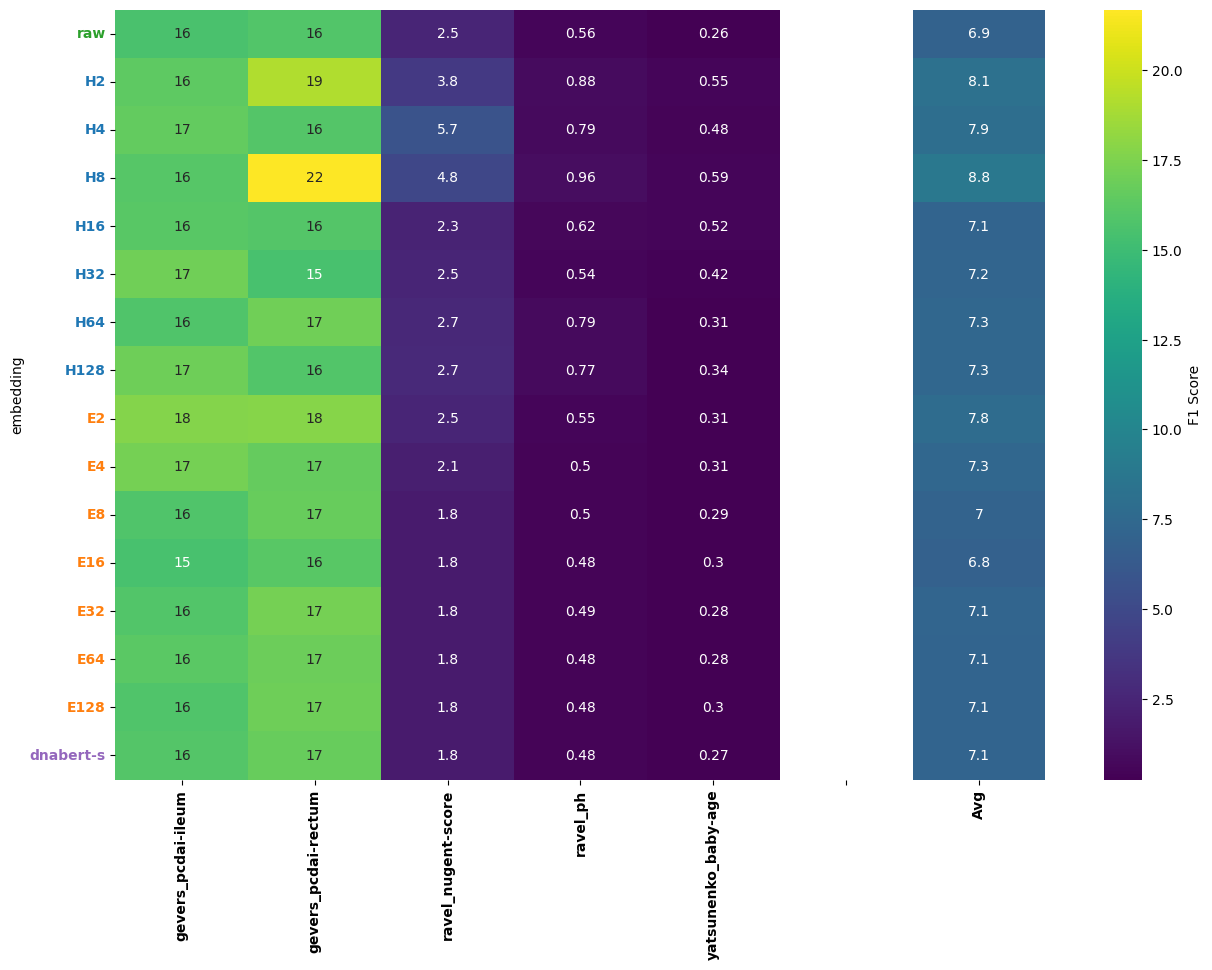

In [36]:
# Report average AUC for each (embedding, task) pair, averaged over folds
import seaborn as sns
import matplotlib.pyplot as plt

# METRIC = "auc"
METRIC = "rmse"

scores_auc = scores[scores["metric"] == METRIC]
scores_auc_mean = scores_auc.groupby(["embedding", "task"])["score"].mean()
scores_auc_mean_pivot = scores_auc_mean.unstack()
scores_auc_mean_pivot = scores_auc_mean_pivot.reindex(EMBEDDINGS)

# Compute row-wise average over tasks for the metric "f1"
avg_series = scores_auc_mean_pivot.mean(axis=1)

# Create a gap column (all NaNs) with a name that shows as a blank header
gap_column = pd.Series(np.nan, index=scores_auc_mean_pivot.index, name=" ")

# Create a new DataFrame: original tasks, then gap, then average
df_heatmap = pd.concat([scores_auc_mean_pivot, gap_column, avg_series.rename("Avg")], axis=1)


def get_color(name):
    if name.startswith("H"):
        return "C0"
    elif name.startswith("E"):
        return "C1"
    elif name == "raw":
        return "C2"
    elif name == "dnabert-s":
        return "C4"
    else:
        return "C3"


# Plot heatmap
fig = plt.figure(figsize=(15, 10))
ax = sns.heatmap(df_heatmap, annot=True, cmap="viridis", cbar_kws={"label": "F1 Score"})
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, weight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, weight="bold")

# Add a vertical line to demarcate the gap between tasks and the Avg column.
# Here, tasks columns count is:
num_tasks = scores_auc_mean_pivot.shape[1]
# ax.axvline(x=num_tasks + 0.5, color="black", lw=3)

# Apply color to ytick labels as before
for i, label in enumerate(df_heatmap.index):
    color = get_color(label)
    ax.get_yticklabels()[i].set_color(color)

plt.show()
# plt.savefig(f"figures/benchmarks/heatmap_{task}_{metric}_rf.pdf", bbox_inches="tight", dpi=300)

In [39]:
# Save as LaTeX table
scores_auc_mean_pivot.T[["raw", "H128", "E128", "dnabert-s"]].to_latex(
    buf="../figures/benchmark_scores_rf5_regression.tex", index=True, float_format="%.3f"
)

In [40]:
scores_auc_mean_pivot.T[["raw", "H128", "E128", "dnabert-s"]]

embedding,raw,H128,E128,dnabert-s
task,,,,
gevers_pcdai-ileum,15.539348,16.954715,15.789825,15.980754
gevers_pcdai-rectum,15.878725,15.880576,16.998856,16.745326
ravel_nugent-score,2.493934,2.718947,1.774225,1.783321
ravel_ph,0.557291,0.770555,0.475275,0.480223
yatsunenko_baby-age,0.258835,0.339921,0.303955,0.270239


: 